<a href="https://colab.research.google.com/github/abt34/HTML-CSS-practice-and-projects/blob/main/pneumonia-classifier(X-ray).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # 1. Install dependencies, including Kaggle and Gradio
!pip install tensorflow scikit-learn matplotlib pandas kaggle gradio -q

# 2. Upload Kaggle Credentials
from google.colab import files
import os

print("--- UPLOADING KAGGLE CREDENTIALS ---")
print("Please select your 'kaggle.json' file from your local machine when prompted.")

# This opens the upload dialog
uploaded = files.upload()

# Check if the file was uploaded
if 'kaggle.json' in uploaded:
    # 3. Configure Kaggle API credentials
    # Create the .kaggle directory and copy the credentials there
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\n Kaggle API configured successfully.")
else:
    print("\n Error: 'kaggle.json' not uploaded. Please ensure the file is in the current directory.")

# 4. Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gradio as gr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import zipfile

print(f"TensorFlow version: {tf.version}")

--- UPLOADING KAGGLE CREDENTIALS ---
Please select your 'kaggle.json' file from your local machine when prompted.


Saving kaggle.json to kaggle.json

 Kaggle API configured successfully.
TensorFlow version: <module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.12/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [2]:
# --- Configuration ---
# Kaggle API slug for the popular chest X-ray dataset
DATASET_SLUG = 'paultimothymooney/chest-xray-pneumonia'
ZIP_FILE = 'chest-xray-pneumonia.zip'
DATA_DIR = '/content/chest_xray_data'

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
RANDOM_SEED = 42
EPOCHS = 10
class_names = ['NORMAL', 'PNEUMONIA']

# 1. Download the Dataset
print("Downloading dataset...")
!kaggle datasets download -d {DATASET_SLUG} -p /content/

# 2. Extract the data
print("Extracting data...")
os.makedirs(DATA_DIR, exist_ok=True)
with zipfile.ZipFile(os.path.join('/content', ZIP_FILE), 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

# 3. Define the directory paths (Handling common nesting issues)
base_dir = os.path.join(DATA_DIR, 'chest_xray')

# Check for the common nested folder structure
if not os.path.exists(os.path.join(base_dir, 'train')):
    # Assume the extracted folder is chest_xray_data/chest_xray/chest_xray
    base_dir = os.path.join(DATA_DIR, 'chest_xray_data', 'chest_xray')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Check one final time before starting generators
if not os.path.exists(train_dir):
    print(f"Final path check failed! Train directory not found at: {train_dir}")
else:
    print(f" Data structure confirmed at: {base_dir}")

# 4. Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)
validation_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=RANDOM_SEED
)

val_ds = validation_test_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=RANDOM_SEED
)

test_ds = validation_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=RANDOM_SEED
)

print("\nTraining samples loaded successfully.")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.25G/2.29G [00:21<00:00, 83.5MB/s]
100% 2.29G/2.29G [00:21<00:00, 116MB/s] 
Extracting data...
 Data structure confirmed at: /content/chest_xray_data/chest_xray
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Training samples loaded successfully.


In [3]:
# Load VGG16 base model, pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base layers
for layer in base_model.layers:
    layer.trainable = False

# Build the sequential model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [4]:
# Calculate steps per epoch
steps_per_epoch = train_ds.samples // BATCH_SIZE
validation_steps = val_ds.samples // BATCH_SIZE

print(f"Starting training for {EPOCHS} epochs...")

history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    epochs=EPOCHS
)

Starting training for 10 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 678ms/step - accuracy: 0.8756 - loss: 0.2999 - val_accuracy: 0.8125 - val_loss: 0.3702
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 624ms/step - accuracy: 0.9536 - loss: 0.1244 - val_accuracy: 0.9375 - val_loss: 0.2389
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 630ms/step - accuracy: 0.9551 - loss: 0.1125 - val_accuracy: 0.9375 - val_loss: 0.2371
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 626ms/step - accuracy: 0.9643 - loss: 0.0909 - val_accuracy: 0.8750 - val_loss: 0.2367
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 630ms/step - accuracy: 0.9701 - loss: 0.0842 - val_accuracy: 0.8750 - val_loss: 0.2327
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 640ms/step - accuracy: 0.9680 - loss: 0.0841 - val_accuracy: 0.7500 - val_loss: 0.3798
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 631ms/step - accuracy: 0.9693 - loss: 0.0757 - val_accuracy: 0.8750 - val_loss: 0.2491
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 642ms/step - accuracy: 0.9676 -

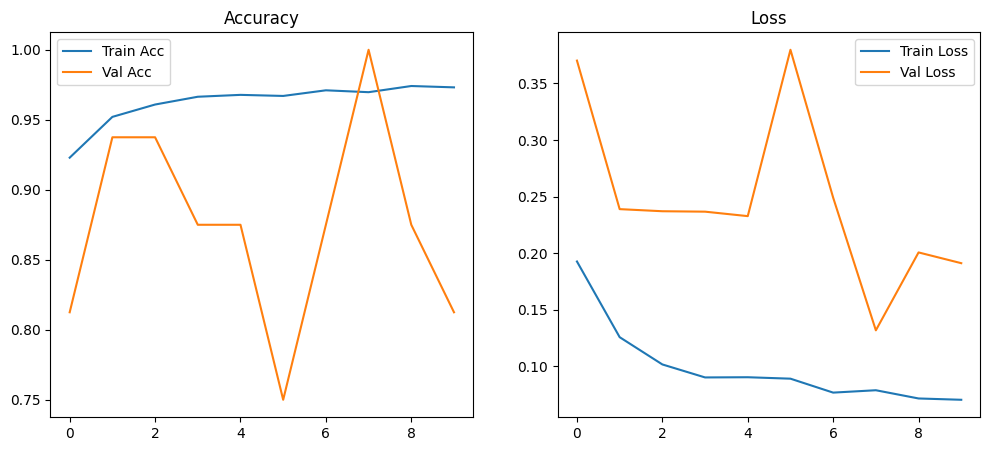


--- Evaluating Model on Test Set ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step



--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

      NORMAL       0.98      0.70      0.81       234
   PNEUMONIA       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.90      0.88      0.88       624


--- Confusion Matrix ---
[[163  71]
 [  3 387]]
 Model saved as chest_xray_vgg16.h5


In [5]:
# 1. Plot Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

# 2. Evaluation
print("\n--- Evaluating Model on Test Set ---")
test_ds.reset()
predictions = model.predict(test_ds, steps=len(test_ds))
y_pred = (predictions > 0.5).astype(int)
y_true = test_ds.classes
y_pred_flat = y_pred.flatten()

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_true, y_pred_flat, target_names=class_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred_flat)
print(cm)

# 3. Save Model to the Colab environment
model_save_file = "chest_xray_vgg16.h5"
model.save(model_save_file)
print(f" Model saved as {model_save_file}")

In [6]:
import tensorflow as tf
import numpy as np
import gradio as gr
import os

# Define constants
IMG_SIZE = (224, 224)
class_names = ['NORMAL', 'PNEUMONIA']
model_save_file = "chest_xray_vgg16.h5"

# Descriptions for better output
descriptions = {
    "NORMAL": "The model detects no signs of Pneumonia. The lungs appear healthy.",
    "PNEUMONIA": "The model detects a high probability of Pneumonia. This is indicated by signs of consolidation or infiltrates. Disclaimer: This is not a medical diagnosis."
}

# Load the saved model
try:
    model_loaded = tf.keras.models.load_model(model_save_file)
    print("Model loaded for Gradio demo.")
except Exception as e:
    print(f"Error loading model for Gradio: {e}")
    model_loaded = None

def predict_xray(image):
    if model_loaded is None:
         return "Model Loading Failed", "0.00%", "Please check model save path and file."

    try:
        if image is None:
            return "No image uploaded.", "0.00%", ""

        img = tf.image.resize(image, IMG_SIZE)
        img = tf.expand_dims(img, 0) / 255.0

        pred = model_loaded.predict(img)

        # Determine prediction and confidence
        confidence_pneumonia = pred[0][0]

        if confidence_pneumonia >= 0.5:
            result = class_names[1] # PNEUMONIA
            confidence = float(confidence_pneumonia)
        else:
            result = class_names[0] # NORMAL
            confidence = float(1.0 - confidence_pneumonia)

        description = descriptions.get(result, "Check code for class names.")

        return result, f"{confidence*100:.2f}%", description

    except Exception as e:
        return "Prediction Error", "0.00%", str(e)

demo = gr.Interface(
    fn=predict_xray,
    inputs=gr.Image(type="numpy", label="Upload Chest X-ray Image"),
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Textbox(label="Confidence"),
        gr.Textbox(label="Clinical Note")
    ],
    title="⚕️ Chest X-ray Classification Demo (VGG16 Transfer Learning)",
    description="Upload a chest X-ray image to detect if it is NORMAL or PNEUMONIA."
)

demo.launch(share=True)

Model loaded for Gradio demo.
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5808df2603a60389e9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
